In [3]:
import tensorflow as tf
import pandas as pd
import librosa
import librosa.display
%matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio

import numpy as np
import pickle

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [8]:
csv_df = pd.read_csv("groove/info.csv")
train_df = csv_df[(csv_df.split=="train")]
train_df

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
10,drummer1,drummer1/session1,drummer1/session1/1,funk,80,beat,4-4,drummer1/session1/1_funk_80_beat_4-4.mid,drummer1/session1/1_funk_80_beat_4-4.wav,86.704688,train
11,drummer1,drummer1/session1,drummer1/session1/10,jazz/funk,116,fill,4-4,drummer1/session1/10_jazz-funk_116_fill_4-4.mid,drummer1/session1/10_jazz-funk_116_fill_4-4.wav,1.872843,train
12,drummer1,drummer1/session1,drummer1/session1/100,neworleans/secondline,94,beat,4-4,drummer1/session1/100_neworleans-secondline_94...,drummer1/session1/100_neworleans-secondline_94...,135.365719,train
13,drummer1,drummer1/session1,drummer1/session1/101,dance/disco,120,beat,4-4,drummer1/session1/101_dance-disco_120_beat_4-4...,drummer1/session1/101_dance-disco_120_beat_4-4...,207.572917,train
14,drummer1,drummer1/session1,drummer1/session1/102,funk,95,beat,4-4,drummer1/session1/102_funk_95_beat_4-4.mid,drummer1/session1/102_funk_95_beat_4-4.wav,224.807558,train
...,...,...,...,...,...,...,...,...,...,...,...
1145,drummer2,drummer2/session2,drummer2/session2/11,rock,130,beat,4-4,drummer2/session2/11_rock_130_beat_4-4.mid,NaN,1.909613,train
1146,drummer2,drummer2/session2,drummer2/session2/12,rock,130,beat,4-4,drummer2/session2/12_rock_130_beat_4-4.mid,NaN,1.808652,train
1147,drummer2,drummer2/session2,drummer2/session2/13,rock,130,beat,4-4,drummer2/session2/13_rock_130_beat_4-4.mid,NaN,1.864421,train
1148,drummer2,drummer2/session2,drummer2/session2/14,rock,130,beat,4-4,drummer2/session2/14_rock_130_beat_4-4.mid,NaN,1.875960,train


In [10]:
y,sr = librosa.load("groove/drummer1/session1/1_funk_80_beat_4-4.wav")
sec = sr * 3 #how many seconds to take from audio
buffer = sr // 4 #how many seconds to play after onset

In [11]:
y = y[:sec]

C:\Users\pdimo\AppData\Local\Temp\ipykernel_11960\2745384297.py:1: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y,sr=sr, x_axis='time', color='red')


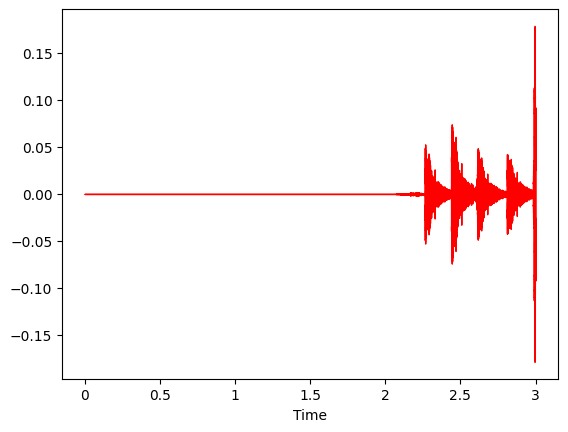

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [12]:
librosa.display.waveshow(y,sr=sr, x_axis='time', color='red')

In [160]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
beat_times = librosa.frames_to_time(beats)

In [161]:
o_env = librosa.onset.onset_strength(y=y, sr=sr)
times = librosa.times_like(o_env, sr=sr)
onset_frames = librosa.onset.onset_detect(y, sr=sr, onset_envelope=o_env, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
onset_times = librosa.frames_to_time(onset_frames)

C:\Users\pdimo\AppData\Local\Temp\ipykernel_18532\2767606875.py:3: FutureWarning: Pass y=[-0.09351148 -0.13613151 -0.11835635 ... -0.00267089  0.00210816
  0.00056728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames = librosa.onset.onset_detect(y, sr=sr, onset_envelope=o_env, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)


Spectrogram config

In [162]:
hop_length = 128
n_fft = 256
bins_per_octave = 12
data = y
y_axis = "linear"
cmap = 'jet'
auto_aspect = False

D = librosa.amplitude_to_db(
    np.abs(librosa.stft(data, hop_length=hop_length, n_fft=n_fft)), ref=np.max)

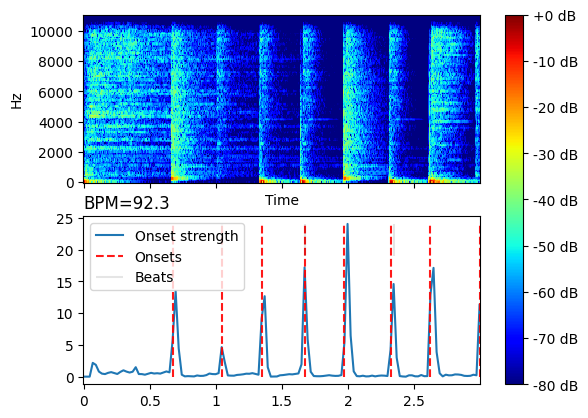

In [163]:
fig, ax = plt.subplots(nrows=2, sharex=True)
plt.title("BPM="+str("%.1f" % tempo), loc="left")
img = librosa.display.specshow(D, y_axis=y_axis, sr=sr,
                               hop_length=hop_length, x_axis='time', ax=ax[0], cmap=cmap, bins_per_octave=bins_per_octave,
                               auto_aspect=auto_aspect)

ax[1].plot(times, o_env, label='Onset strength')
ax[1].vlines(onset_times, 0, o_env.max(), color='r', alpha=0.9, linestyle='--', label='Onsets')
ax[1].vlines(beat_times, o_env.max()-5, o_env.max(), color='k', alpha=0.1, label='Beats')
ax[1].legend()
fig.colorbar(img, ax=ax, format='%+2.0f dB')

In [182]:
onset_slices = [round(x*sr) for x in onset_times]
audios = []

for x in onset_slices:
    audios.append(y[x:x+buffer])

In [183]:
onset_slices

[14848, 23040, 29696, 36864, 43520, 51200, 57856, 66048]

In [187]:
Audio(audios[6], rate=sr)